# This notebook create plots for data-model-comparison
This notebook create zonal lat. averaged temperatures for Darrell.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy

In [2]:
#No change needs here
 #PMIP model list used in this notebook represents CMIP models included in PMIP
'''Define CMIP list'''

def whole_model_list():
    filename_xls='PMIP & CMIP model data status.xlsx'
    wb=xlrd.open_workbook(filename_xls)
    sh_pmip4 = wb.sheet_by_name('PMIP4-CMIP6')
    model_id4=sh_pmip4.col_values(14, 6, 28)
    cmip6=[]
    cmip6_generation=sh_pmip4.col_values(20, 6, 28)
    pmip4_generation=sh_pmip4.col_values(21, 6, 28)
    for i in range(len(model_id4)):
        if (cmip6_generation[i]=='CMIP6' and pmip4_generation[i]=='PMIP4'):
            cmip6.append(model_id4[i])
    cmip5=[]
    sh_pmip3 = wb.sheet_by_name('PMIP3-CMIP5')
    model_id3=sh_pmip3.col_values(12, 2, 20)
    cmip5_generation=sh_pmip3.col_values(18, 2, 20)
    pmip3_generation=sh_pmip3.col_values(19, 2, 20)
    for i in range(len(model_id3)):
        if (cmip5_generation[i]=='CMIP5' and pmip3_generation[i]=='PMIP3'):
            cmip5.append(model_id3[i])
    return model_id4,cmip6,model_id3,cmip5

#PMIP4-CMIP6
#Cell range: B6 - X28
#Below: No values are corresponed No in python
# model row No.: 6-27
# col_No. col.  experiment/column content

#    4      E    0kpiControl
#    5      F    LMpast1000(1000 years)
#    6      G    6kmidHolocene
#    7      H    21klgm
#    8      I    Last Interglaciallig127k
#    9      J    Mid Pliocene warm periodmidPliocene-eoi400

#    14     O    Model id
#    20     U    CMIP6
#    21     V    PMIP4

#PMIP3-CMIP5
#Cell range: B2 - U20
#Below: No values are corresponed No in python
# model row No.: 2-19
# col_No. col.  experiment/column content

#    3      D    0kpiControl
#    4      E    LMpast1000(1000 years)
#    5      F    6kmidHolocene
#    6      G    21klgm
#    7      H    Last Interglaciallig127k
#    8      I    Mid Pliocene warm periodmidPliocene-eoi400   

#    12     M    Model id
#    18     S    CMIP6
#    19     T    PMIP4


pmip4,cmip6,pmip3,cmip5=whole_model_list()

pmip={}
pmip['PMIP3']=cmip5
pmip['PMIP4']=cmip6

pmip_v4='PMIP4'
pmip_v3='PMIP3'

In [2]:
pmip4=['IPSL-CM6A-LR',
       'HadGEM3-GC31',
       'AWI-ESM']

pmip3=['GISS-E2-1-G',
     'COSMOS-ASO',
     'MRI-CGCM3',
     'CNRM-CM5',
     'FGOALS-g2',
     'GISS-E2-R',
     'EC-EARTH-2-2',
     'IPSL-CM5A-LR',
     'bcc-csm1-1',
     'HadGEM2-CC',
     'HadCM3',
     'MPI-ESM-P',
     'CCSM4',
     'CSIRO-Mk3L-1-2',
     'CSIRO-Mk3-6-0',
     'FGOALS-s2',
     'MIROC-ESM']
pmip_all=['GISS-E2-1-G',
 'COSMOS-ASO',
 'AWI-ESM',
 'MRI-CGCM3',
 'CNRM-CM5',
 'FGOALS-g2',
 'GISS-E2-R',
 'EC-EARTH-2-2',
 'IPSL-CM5A-LR',
 'IPSL-CM6A-LR',
 'bcc-csm1-1',
 'HadGEM3-GC31',
 'HadGEM2-CC',
 'HadCM3',
 'MPI-ESM-P',
 'CCSM4',
 'CSIRO-Mk3L-1-2',
 'CSIRO-Mk3-6-0',
 'FGOALS-s2',
 'MIROC-ESM']

pmip={}
pmip['PMIP3']=pmip3
pmip['PMIP4']=pmip4
pmip['PMIP']=pmip_all

pmip_v3='PMIP3'
pmip_v4='PMIP4'

In [3]:
#No change needs here

'''Define calculating functions'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "data" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='data/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="data/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

#This function will list excat model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    
#This function will find an regird avaiable models, calculate changes, and return model data and model names
def ensemble_diffence(pmip_v):
    dataset={}
    model=[]
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                dataset[gcm]=diff_1x1
                model.append(gcm)
    return dataset,model

#x=np.arange(0,181,20)
#xla=['-90 ~ -70','-70 ~ -50','-50 ~ -30','-30 ~ -10','-10 ~ 10','10 ~ 30','30 ~ 50','50 ~ 70','70 ~ 90']
x=np.arange(0,181,30)
xla=['-90 ~ -60','-60 ~ -30','-30 ~ 0','0 ~ 30','30 ~ 60','60 ~ 90']
#This function will calculate zonal means of every 20 deg in latitude
def zonal_mean(pmip_v):
    ensemble_diff_v,model_diff_v=ensemble_diffence(pmip_v)
    data={}
    for m in model_diff_v:
        data[m]=[]
        for i in range(len(x)-1):
            men=ensemble_diff_v[m][x[i]:x[i+1]]
            xx=np.average(men)
            data[m].append(xx)
    return data

#This function will plot zonal data
def zonal_scatter(data):
    fig=plt.figure(figsize=(10,7))
    for m in model_diff_v:
        plt.scatter(data[m],xla,marker='o',s=50,label=m)
    plt.legend()
    plt.axvline(x=0,color='k',linestyle="--")
    plt.ylabel('latitude (deg_N)')
    plt.xlabel('changes in TAS (midHolocene - piControl)')
    return fig

#This function will combine all functions above
def zonal_plot(pmip_v):
    ensemble_diff_v,model_diff_v=ensemble_diffence(pmip_v)
    data={}
    for m in model_diff_v:
        data[m]=[]
        for i in range(len(x)-1):
            men=ensemble_diff_v[m][x[i]:x[i+1]]
            xx=np.average(men)
            data[m].append(xx)
    plt.figure(figsize=(10,10))
    plt.axvline(x=0,color='k',linestyle="--")
    for m in model_diff_v:
        plt.scatter(data[m],xla,marker='o',s=50,label=m)
    plt.legend()
    plt.ylabel('latitude (deg_N)')
    x_label='changes in %s (%s - piControl)' %(variable_name,experiment_name)
    plt.xlabel(x_label)
    plt.plot(0,)
    plt.title(pmip_v)

    

Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc


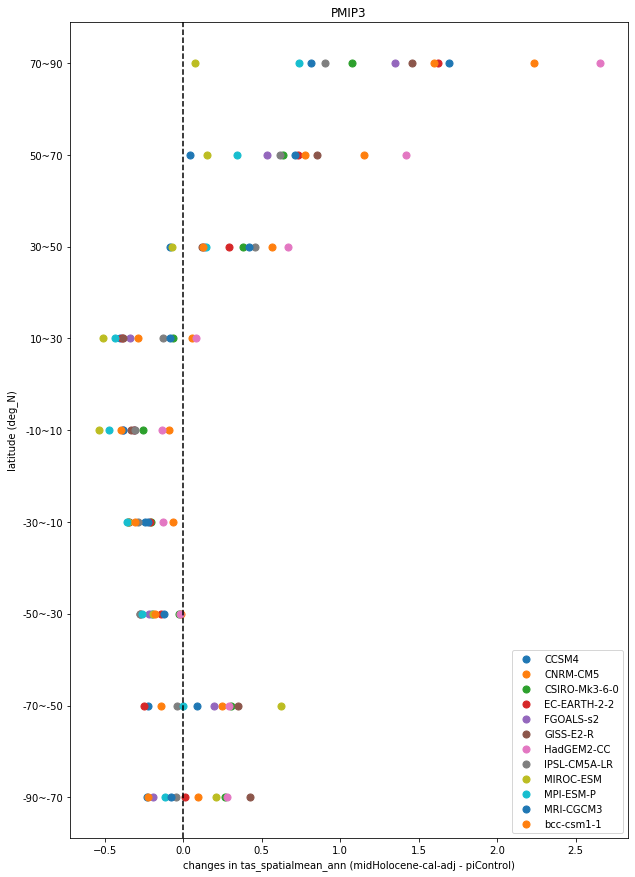

In [32]:
'''Set experiment and variable names'''
experiment_name='midHolocene-cal-adj'
variable_name='tas_spatialmean_ann'


zonal_plot(pmip_v3)


Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc


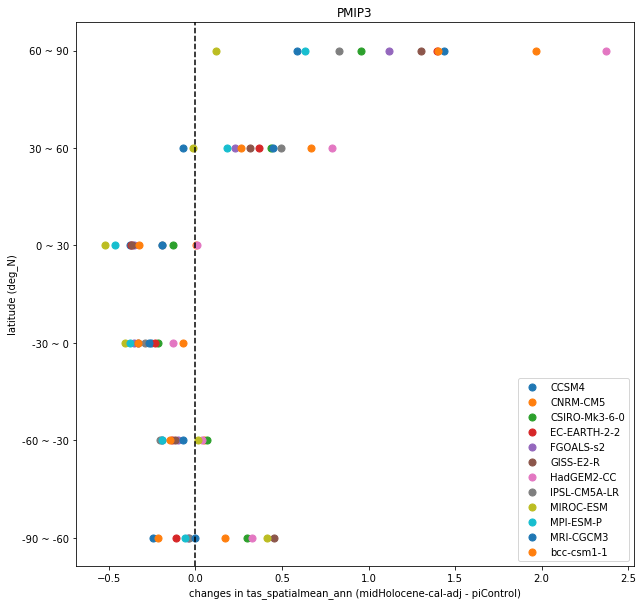

In [9]:
experiment_name='midHolocene-cal-adj'
variable_name='tas_spatialmean_ann'


zonal_plot(pmip_v3)

